## Model

In [29]:
using Revise, ReachabilityAnalysis, SparseArrays, Plots, BenchmarkTools
LazySets.set_rtol(Float64, 1e-14);
LazySets.set_ztol(Float64, 1e-14);

boxdirs = BoxDirections{Float64, Vector{Float64}}(10)

BoxDirections{Float64,Array{Float64,1}}(10)

In [ ]:
#using SX
#file = "ARCH14-Platoon/Input_SpaceEx/platoon_continuous.xml"
#H = readsxmodel(file, raw_dict=true) # ST=ConstrainedLinearControlContinuousSystem);
#@save "building.jld2" H
#H["invariants"]

In [25]:
function platoon_connected(; deterministic_switching::Bool=true,
                             c1=5.0)  # clock constraints
    n = 10 # 9 dimensions + time
    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, -0.8198, 0.4270, -0.0450, -0.1942,  0.3626, -0.0946, 0.]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0.8718, 3.8140, -0.0754,  1.1936, 3.6258, -3.2396, -0.5950,  0.1294, -0.0796, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    if deterministic_switching
        invariant = HalfSpace(sparsevec([n], [1.], n), c1) # t <= c1
    else
        invariant = Universe(n)
        # ? HalfSpace(sparsevec([n], [1.], n), tb) # t <= tb
    end
    
    # acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

platoon_connected (generic function with 1 method)

In [26]:
function platoon_disconnected(; deterministic_switching::Bool=true,
                                c2=5.0)  # clock constraints
    n = 10 # 9 dimensions + time
    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, 0, 0, 0, 0, 0, 0, 0]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0, 0, 0,  1.1936, 3.6258, -3.2396, 0, 0, 0, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    if deterministic_switching
        invariant = HalfSpace(sparsevec([n], [1.], n), c2) # t <= c2
    else
        invariant = Universe(n) # t is not constrained
    end
    
    # acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

platoon_disconnected (generic function with 1 method)

$$
α Ac + (1-α)An
$$

In [27]:
function platoon_continuous()
    m1 = platoon_connected()
    m2 = platoon_disconnected();
    Ac = state_matrix(m1)
    An = state_matrix(m2)
    Aint = IntervalMatrix(An + interval(0, 1) .* (Ac - An));
    # acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1) |> IntervalMatrix
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    invariant = Universe(n)
    @system(x' = Aint*x, x ∈ invariant) #  + IntervalMatrix(B)*u, x ∈ invariant, u ∈ U)
end

platoon_continuous (generic function with 1 method)

In [28]:
function platoon(; deterministic_switching::Bool=true,
                   c1=5.0,  # clock constraints
                   c2=5.0,  # clock constraints
                   tb=10.0,  # lower bound for loss of communication
                   tc=20.0, tr=20.0) # upper bound for loss of communication (tc) and reset time (tr)
    
    # three variables for each vehicle, (ei, d(et)/dt, ai) for
    # (spacing error, relative velocity, speed), and the last dimension is time
    n = 9 + 1

    # transition graph
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)

    # modes
    mode1 = platoon_connected(deterministic_switching=deterministic_switching, c1=c1)
    mode2 = platoon_disconnected(deterministic_switching=deterministic_switching, c2=c2)
    modes = [mode1, mode2]

    # common reset
    reset = Dict(n => 0.)

    # transition l1 -> l2
    if deterministic_switching
        guard = Hyperplane(sparsevec([n], [1.], n), c1) # t == c1
    else
        # tb <= t <= tc
        guard = HPolyhedron([HalfSpace(sparsevec([n], [-1.], n), -tb),
                             HalfSpace(sparsevec([n], [1.], n), tc)])
    end
    t1 = ConstrainedResetMap(n, guard, reset)

    # transition l2 -> l1
    if deterministic_switching
        guard = HalfSpace(sparsevec([n], [1.], n), c2) # t == c2
    else
        guard = HalfSpace(sparsevec([n], [1.], n), tr) # t <= tr
    end
    t2 = ConstrainedResetMap(n, guard, reset)
    resetmaps = [t1, t2]

    H = HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])

    # initial condition is at the orgin in mode 1
    X0 = BallInf(zeros(n), 0.0)
    initial_condition = [(1, X0)]

    return IVP(H, initial_condition)
end

platoon (generic function with 1 method)

# Arbitrary switching

TODO: idea: use ASB07 as in CORA.

Currently fails because of an unsupported system.

In [76]:
X0 = BallInf(zeros(n), 0.0)
ivp = @ivp(platoon_continuous(), x(0) ∈ X0);
sol = solve(ivp, T=20.0, alg=ASB07(δ=1e-2));
plot(sol, vars=(0, 1))

ArgumentError: ArgumentError: the system type ConstrainedLinearContinuousSystem{IntervalArithmetic.Interval{Float64},IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}},Universe{Float64}} is currently not supported

# Deterministic switching (PLAD01)

## PLAD01 - BND42

In [41]:
prob = platoon(; deterministic_switching=true);
@time sol = solve(prob, alg=BOX(δ=0.005), max_jumps=1000,
                  clustering_method=LazyClustering(15), # , [6,1,1,1,1,1,1,1,1,1]),
                  intersection_method=TemplateHullIntersection(boxdirs),
                  intersect_source_invariant=false,
                  tspan = (0.0 .. 20.0));

@show tspan(sol); # TODO: fix `tspan` for a hybrid flowpipe.
@show -ρ(sparsevec([1], [-1.0], 10), sol)
@show -ρ(sparsevec([4], [-1.0], 10), sol)
@show -ρ(sparsevec([7], [-1.0], 10), sol)

  6.448602 seconds (19.11 M allocations: 1.909 GiB, 9.01% gc time)
tspan(sol) = [0, 10.0001]
-(ρ(sparsevec([1], [-1.0], 10), sol)) = -56.261838312897495
-(ρ(sparsevec([4], [-1.0], 10), sol)) = -52.256290727684764
-(ρ(sparsevec([7], [-1.0], 10), sol)) = -40.208886481449696


-40.208886481449696

In [134]:
plot(sol, vars=(0, 1), lw=0.0, color=:blue)

InterruptException: SYSTEM: show(lasterr) caused an error

In [113]:
-ρ(sparsevec([1], [-1.0], 10), sol)

-57.50151479398824

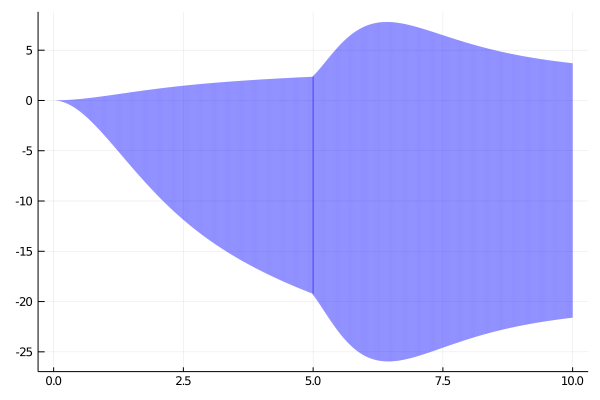

In [101]:
plot(sol[1], vars=(0, 1), lw=0.0, color=:blue)
plot!(sol[2], vars=(0, 1), lw=0.0, color=:blue)

### PLAD01 - BND30

# Non-deterministic switching  (PLAN01)

In [22]:
boxdirs = BoxDirections{Float64, Vector{Float64}}(10)
prob = platoon(; deterministic_switching=false);
@time sol = solve(prob, alg=BOX(δ=0.01), max_jumps=1000,
                  clustering_method=LazyClustering(10), # , [6,1,1,1,1,1,1,1,1,1]),
                  intersection_method=TemplateHullIntersection(boxdirs),
                  intersect_source_invariant=false,
                  tspan = (0.0 .. 20.));

  0.791288 seconds (2.96 M allocations: 299.121 MiB, 8.21% gc time)


In [23]:
@show tspan(sol);
@show -ρ(sparsevec([1], [-1.0], 10), sol)
@show -ρ(sparsevec([4], [-1.0], 10), sol)
@show -ρ(sparsevec([7], [-1.0], 10), sol)

tspan(sol) = [0, 20.0101]
-(ρ(sparsevec([1], [-1.0], 10), sol)) = -31.650693462773305
-(ρ(sparsevec([4], [-1.0], 10), sol)) = -28.64336283867606
-(ρ(sparsevec([7], [-1.0], 10), sol)) = -14.706195406096054


-14.706195406096054

In [ ]:
plot(sol, vars=(0, 1), lw=0.0)

In [ ]:
plot(sol, vars=(0, 1), lw=0.0, color=:lightgreen, xlab="x", ylab="y")

BNDxy Bounded time (no explicit bound on the number of transitions): 

For all t ∈ [0, 20] [s],

- x 1 (t) ≥ −d min [m], 
- x 4 (t) ≥ −d min [m], 
- x 7 (t) ≥ −d min [m], where d min =xy [m].

BND50: d min = 50.
BND42: d min = 42.
BND30: d min = 30

In [ ]:
sol = nothing
GC.gc()

boxdirs = BoxDirections{Float64, Vector{Float64}}(10)
octdirs = CustomDirections([Vector(c) for c in OctDirections(10)])

dmin = 30.0
prob = platooning2(; deterministic_switching=true, time_horizon=20., allowed_distance=dmin)

#prob = platooning(; deterministic_switching=true, time_horizon=Inf, allowed_distance=50.)

@time sol = solve(prob, alg=BOX(δ=0.01),
                  clustering_method=LazyClustering(10),
                  intersection_method=TemplateHullIntersection(octdirs),
                  intersect_source_invariant=false,
                  intersect_source_invariant_method=TemplateHullIntersection(boxdirs),
                  tspan = (0.0 .. 20.));

In [ ]:
@show ρ(sparsevec([1], [-1.0], 10), sol)

In [ ]:
plot(sol, vars=(0, 1), lw=0.0)

In [ ]:
location.(sol)

In [ ]:
@show tspan(sol);
@show ρ(sparsevec([1], [-1.0], 10), sol) < dmin
@show ρ(sparsevec([4], [-1.0], 10), sol) < dmin
@show ρ(sparsevec([7], [-1.0], 10), sol) < dmin

-----

In [ ]:
sol = nothing
GC.gc()

boxdirs = BoxDirections{Float64, Vector{Float64}}(10)
octdirs = CustomDirections([Vector(c) for c in OctDirections(10)])

dmin = 30.0
prob = platooning(; deterministic_switching=true, time_horizon=20., allowed_distance=dmin)

#prob = platooning(; deterministic_switching=true, time_horizon=Inf, allowed_distance=50.)

@time sol = solve(prob, alg=GLGM06(δ=0.0001, max_order=200, disjointness_method=BoxEnclosure()),
                  clustering_method=LazyClustering(1),
                  disjointness_metod=BoxEnclosure(),
                  intersection_method=TemplateHullIntersection(octdirs),
                  intersect_source_invariant=false,
                  intersect_source_invariant_method=TemplateHullIntersection(boxdirs),
                  tspan = (0.0 .. 20.));

In [ ]:
ρ(sparsevec([1], [-1.0], 10), sol)

In [ ]:
function ReachabilityAnalysis._is_intersection_empty(X::LazySet, Z::Zonotope, ::BoxEnclosure)
    is_intersection_empty(X, overapproximate(Z, Hyperrectangle))
end

## Old stuff

In [74]:
    #=
    system = InitialValueProblem(ℋ, initial_condition)

    # safety property
    d1 = zeros(n); d1[1] = -1.  # x1 >= -dmin
    d4 = zeros(n); d4[4] = -1.  # x4 >= -dmin
    d7 = zeros(n); d7[7] = -1.  # x7 >= -dmin
    property = Conjunction(
        [is_contained_in(HalfSpace(d, allowed_distance)) for d in [d1, d4, d7]])

    # default options
    options = Options(:T=>time_horizon, :property=>property)
    =#
